In [1]:
import tensorflow as tf
print("tensorflow version is", tf.__version__)
print("keras version is", tf.keras.__version__)

from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Reshape, Flatten, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.initializers import RandomNormal
import os
import itertools
import matplotlib.pyplot as plt
import numpy as np

plt.ioff()  # not to show images inline
os.makedirs("out4", exist_ok=True)

tensorflow version is 2.1.0
keras version is 2.2.4-tf


In [2]:
def load_preped_data(train_ratio=0.9):
    x = np.load("out4/celeba_preped.npz")["preped"]
    i = np.random.permutation(len(x))
    train_size = int(len(x) * train_ratio)
    x_tr = x[0:train_size]
    x_te = x[train_size:]
    return x_tr, x_te

x_tr, x_te = load_preped_data()

In [3]:
print(x_tr.shape, x_tr.dtype, np.min(x_tr), np.max(x_tr))
print(x_te.shape, x_te.dtype, np.min(x_te), np.max(x_te))

(182052, 80, 80, 3) uint8 0 255
(20229, 80, 80, 3) uint8 0 255


In [4]:
def plot_images(images, nrow=5, ncol=8, figsize=(10, 6)):
    fig, ax = plt.subplots(nrow, ncol, figsize=figsize)
    for i, j in itertools.product(range(nrow), range(ncol)):
        k = i*ncol + j
        if k < len(images):
            ax[i][j].imshow(images[k])
        ax[i][j].xaxis.set_visible(False)
        ax[i][j].yaxis.set_visible(False)
    fig.tight_layout()
    plt.close(fig)
    return fig

sample training images


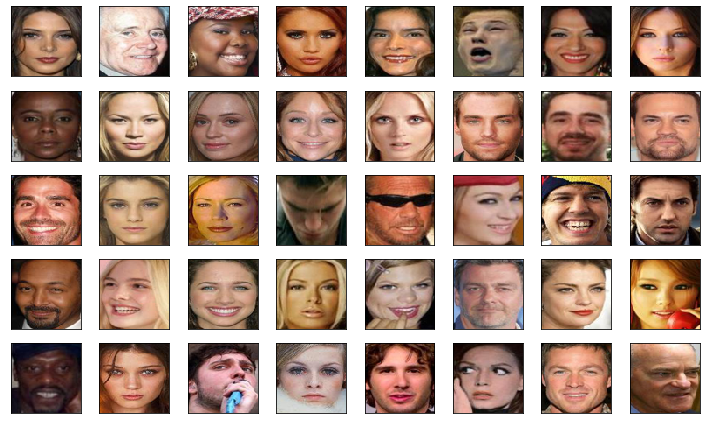

In [5]:
i = np.random.choice(len(x_tr), 40)
print("sample training images")
plot_images(x_tr[i])

sample test images


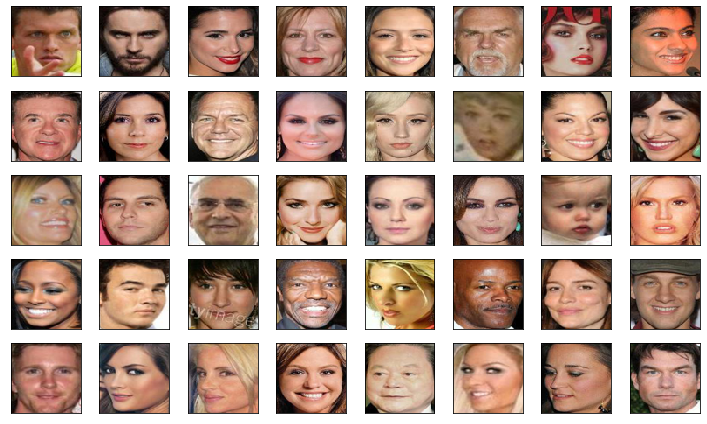

In [6]:
i = np.random.choice(len(x_te), 40)
print("sample test images")
plot_images(x_te[i])

(40, 80, 80, 3) -1.0 1.0


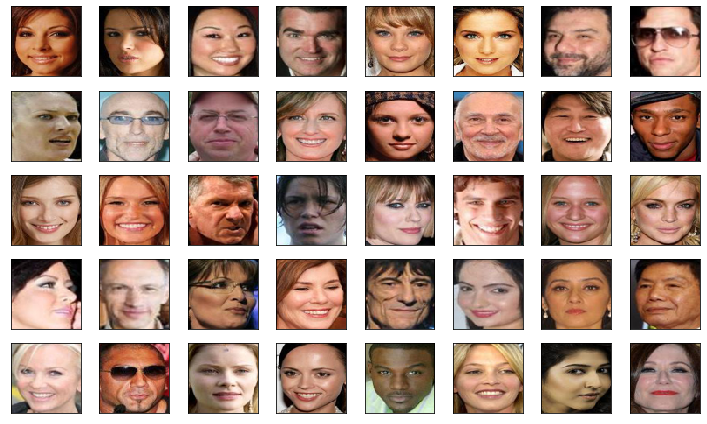

In [17]:
class Dataset:
    def __init__(self, data, normalizer=None):
        self.data = data
        self.normalizer = normalizer
        self.index = 0  # current index
        self.iter_count = 0  # number of completed iteration
        self.order = np.arange(len(data))
        self.randomize()

    def randomize(self):
        self.order = np.random.permutation(self.order)
    
    def get(self, size):
        out = self._get(size)
        if self.normalizer is None:
            return out
        else:
            return self.normalizer(out)

    def _get(self, size):
        n = len(self.data)
        i1 = self.index
        i2 = min(n, self.index + size)
        if i2 >= n:
            self.iter_count += 1
            self.randomize()
        out = self.data[self.order[i1:i2]]
        self.index = (i2 % n)
        if len(out) == size:
            return out
        else:
            size_remain = size - len(out)
            out2 = self.get(size_remain)
            out = np.vstack((out, out2))
            return out

class Normalizer:
    def __init__(self, low=-1.0, high=1.0, dtype="float32"):
        self.low = low
        self.high = high
        self.dtype = dtype
    def __call__(self, x, inv=False):
        out = x * (self.high - self.low) / 255.0 + self.low
        out = out.astype(self.dtype)
        return out

# test
data = Dataset(x_tr, normalizer=Normalizer())
test = data.get(40)
print(test.shape, np.min(test), np.max(test))
test = ((test + 1) * 255 / 2).astype(int)  # rescale to [0, 255]
plot_images(test)

In [18]:
def make_discriminator(filters=(128,128,128,128,128),
                       kernel=(5,5), input_shape=(80,80,3)):
    initializer = RandomNormal(0.0, 0.02)
    x = Input(input_shape)    
    y = x
    for f in filters:
        y = Conv2D(f, kernel, strides=(2,2), padding="same", kernel_initializer=initializer)(y)
        y = LeakyReLU(0.2)(y)
    y = Flatten()(y)
    y = Dropout(0.4)(y)
    y = Dense(1, activation="sigmoid")(y)
    model = Model(inputs=x, outputs=y)
    return model

discriminator = make_discriminator()
discriminator.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 80, 80, 3)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 40, 40, 128)       9728      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 40, 40, 128)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 20, 20, 128)       409728    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 128)       409728    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 10, 10, 128)       0     

In [19]:
def make_generator(latent_size=100, filters=(128,128,128,128), init_filter=128, init_shape=(5,5)):
    initializer = RandomNormal(0.0, 0.02)
    x = Input((latent_size,))
    y = x
    n = init_filter * init_shape[0] * init_shape[1]
    y = Dense(n, kernel_initializer=initializer)(y)
    y = LeakyReLU(0.2)(y)
    y = Reshape(init_shape + (init_filter,))(y)
    for f in filters:
        y = Conv2DTranspose(f, (4,4), strides=(2,2), padding="same", kernel_initializer=initializer)(y)
        y = LeakyReLU(0.2)(y)
    y = Conv2D(3, (5,5), activation="tanh", padding="same")(y)
    model = Model(inputs=x, outputs=y)
    return model

generator = make_generator()
generator.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 3200)              323200    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 3200)              0         
_________________________________________________________________
reshape (Reshape)            (None, 5, 5, 128)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 10, 10, 128)       262272    
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 10, 10, 128)       0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 20, 20, 128)       2622

(6, 80, 80, 3) -0.010529451 0.007420842


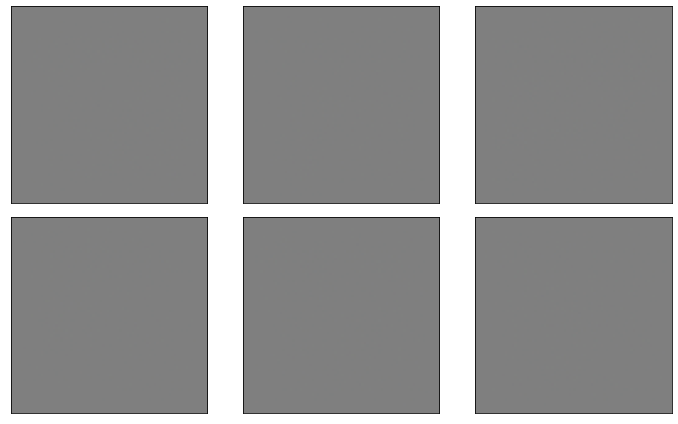

In [20]:
def generate_latent(generator, n_sample=128):
    latent_size = generator.input_shape[1]
    latent = np.random.randn(n_sample, latent_size)
    return latent

def generate_fake_data(generator, n_sample=128):
    latent = generate_latent(generator, n_sample)
    out = generator.predict(latent)
    return out

fake = generate_fake_data(generator, 6).squeeze()  # remove the channels dimension
print(fake.shape, np.min(fake), np.max(fake))
fake = ((fake + 1) * 255 / 2).astype(int)
plot_images(fake, nrow=2, ncol=3)

In [26]:
class GAN:
    def __init__(self, generator, discriminator, data, test_data,
                 name="celaba", **kwargs):
        self.generator = generator
        self.discriminator = discriminator
        self.data = data
        self.test_data = test_data
        self.name = name
        self.setup(**kwargs)
        
    def setup(self,
              lr_d=0.0002, beta1_d=0.5, beta2_d=0.999,
              lr_g=0.0002, beta1_g=0.5, beta2_g=0.999):
        self.discriminator.trainable = True
        opt = Adam(learning_rate=lr_d, beta_1=beta1_d, beta_2=beta2_d)
        self.discriminator.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
        
        self.discriminator.trainable = False
        x = Input(self.generator.input_shape[1:])
        y = self.generator(x)
        y = self.discriminator(y)
        gan = Model(inputs=x, outputs=y)
        opt = Adam(learning_rate=lr_g, beta_1=beta1_g, beta_2=beta2_g)
        gan.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
        self.gan = gan
    
    def train_step(self, batchsize=256, update_discriminator_separately=True):
        # train discriminator
        halfbatch = int(batchsize/2)
        x_real = self.data.get(halfbatch)
        y_real = np.ones((halfbatch, 1))
        x_fake = generate_fake_data(self.generator, halfbatch)
        y_fake = np.zeros((halfbatch, 1))
        if update_discriminator_separately:
            res_d_real = self.discriminator.train_on_batch(x_real, y_real)        
            res_d_fake = self.discriminator.train_on_batch(x_fake, y_fake)
            res_d = tuple((a+b)/2 for a, b in zip(res_d_real, res_d_fake))
        else:
            res_d = self.discriminator.train_on_batch(
                np.vstack((x_real, x_fake)), np.vstack((y_real, y_fake))
            )
        
        # train generator
        x_gan = generate_latent(self.generator, batchsize)
        y_gan = np.ones((batchsize, 1))
        res_g = self.gan.train_on_batch(x_gan, y_gan)
        
        return res_d, res_g
    
    def evaluate(self, iteration, batchsize=256):
        x_real = self.test_data.get(batchsize)
        y_real = np.ones((batchsize, 1))
        loss_real, acc_real = self.discriminator.evaluate(x_real, y_real,
                                                          verbose=False, batchsize=batchsize)
        x_fake = generate_fake_data(self.generator, batchsize)
        y_fake = np.zeros((batchsize, 1))
        loss_fake, acc_fake = self.discriminator.evaluate(x_fake, y_fake, 
                                                          verbose=False, batchsize=batchsize)
        print("\nIter %d: loss=(%.3f, %.3f), acc=(%.3f, %.3f)" % (
              iteration+1, loss_real, loss_fake, acc_real, acc_fake))
        
    def generate_sample_images(self, nrow=4, ncol=8, figsize=(12, 6)):
        fake = generate_fake_data(self.generator, nrow*ncol)
        fake = ((fake + 1) * 255 / 2).astype(int)
        images = plot_images(fake, figsize=figsize, nrow=nrow, ncol=ncol)
        return images
    
    def save_model(self, index):
        path = "out4/%s-generator_%07d.h5" % (self.name, index)
        self.generator.save(path)
        path = "out4/%s-discriminator_%07d.h5" % (self.name, index)
        self.discriminator.save(path)
        
    def train(self, n_iter=10000, batchsize=256, update_discriminator_separately=True,
              eval_by=1000, batchsize_eval=256, startindex=0,
              nrow=4, ncol=8, figsize=(12, 6)):
        # image from the initial generator
        fig = self.generate_sample_images(nrow=nrow, ncol=ncol, figsize=figsize)
        imagepath = "out4/%s_%07d.png" % (self.name, 0)
        fig.savefig(imagepath)
        plt.close(fig)
        history = {"loss_d":[], "loss_g":[], "acc_d":[], "acc_g":[]}
        for i in range(startindex, startindex+n_iter):
            (loss_d, acc_d), (loss_g, acc_g) = self.train_step(
                batchsize, update_discriminator_separately=update_discriminator_separately)
            print("\r#%6d: loss=(%.3f, %.3f), acc=(%.3f, %.3f)" % (i+1, loss_d, loss_g, acc_d, acc_g), end="")
            history["loss_d"].append(loss_d)
            history["loss_g"].append(loss_g)
            history["acc_d"].append(acc_d)
            history["acc_g"].append(acc_g)
            if (i+1) % eval_by == 0:
                self.evaluate(i, batchsize_eval)
                fig = self.generate_sample_images(nrow=nrow, ncol=ncol, figsize=figsize)
                imagepath = "out4/%s_%07d.png" % (self.name, i+1)
                fig.savefig(imagepath)
                plt.close(fig)
                self.save_model(i+1)
        return history

In [23]:
def post_estimation_summary(gan, history):
    fake = generate_fake_data(gan.generator, 32)
    print(fake.shape, np.min(fake), np.max(fake))
    fake = ((fake + 1) * 255 / 2).astype(int)
    fig = plot_images(fake, nrow=4, ncol=8)
    display(fig)
    plt.close(fig)
    
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    n = len(history["loss_d"])
    ax[0].plot(range(1, n+1), history["loss_d"], color="blue", alpha=0.5, label="discriminator")
    ax[0].plot(range(1, n+1), history["loss_g"], color="red", alpha=0.5, label="generator")
    ax[0].set_title("training loss")
    ax[1].plot(range(1, n+1), history["acc_d"], color="blue", alpha=0.5, label="discriminator")
    ax[1].plot(range(1, n+1), history["acc_g"], color="red", alpha=0.5, label="generator")
    ax[1].set_title("training accuracy")
    fig.tight_layout()
    display(fig)
    plt.close(fig)

#     2: loss=(0.310, 0.825), acc=(1.000, 0.000)
Iter 2: loss=(0.003, 0.611), acc=(1.000, 1.000)
#     4: loss=(0.284, 0.945), acc=(1.000, 0.000)
Iter 4: loss=(0.000, 0.520), acc=(1.000, 1.000)
(32, 80, 80, 3) -0.039115787 0.049761824


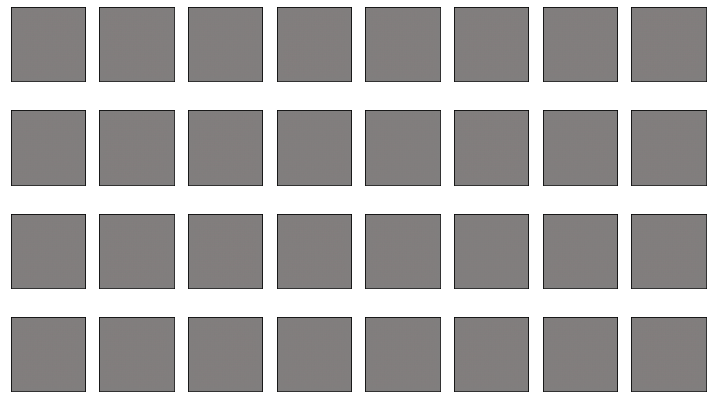

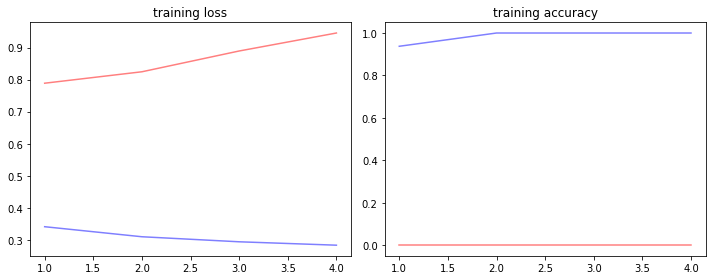

In [25]:
# test
gan = GAN(generator, discriminator, data, data, name="test")
history = gan.train(n_iter=4, batchsize=64, eval_by=2)
post_estimation_summary(gan, history)

In [ ]:
data = Dataset(x_tr, normalizer=Normalizer())
test_data = Dataset(x_te, normalizer=Normalizer())
discriminator = make_discriminator()
generator = make_generator()
gan = GAN(generator, discriminator, data, test_data, name="celeba")
history = gan.train(n_iter=10000, batchsize=256)

post_estimation_summary(gan, history)

#     1: loss=(0.695, 0.692), acc=(0.242, 1.000)

In [ ]:
tmp = gan.train(n_iter=10000, batchsize=256, startindex=len(history["loss_d"]))
history = {name: history[name] + tmp[name] for name in history}
post_estimation_summary(gan, history)

In [2]:
tmp = gan.train(n_iter=10000, batchsize=256, startindex=len(history["loss_d"]))
history = {name: history[name] + tmp[name] for name in history}
post_estimation_summary(gan, history)

NameError: name 'history' is not defined

In [ ]:
tmp = gan.train(n_iter=10000, batchsize=256, startindex=len(history["loss_d"]))
history = {name: history[name] + tmp[name] for name in history}
post_estimation_summary(gan, history)

In [ ]:
tmp = gan.train(n_iter=10000, batchsize=256, startindex=len(history["loss_d"]))
history = {name: history[name] + tmp[name] for name in history}
post_estimation_summary(gan, history)